In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import pandas_ta as ta
from scipy.stats import linregress

In [2]:
from multiprocessing import Pool, Lock

lock = Lock()

def calculate_tau(window, ords, x):
    #print(ords, x)
    return kendalltau(ords, x)[0]

def add_kendall_tau(data, window=10):
    ords = range(window)
    l = [(window, ords, x) for x in data['Close'].rolling(window)]

    print(l)
    with Pool() as pool:
        data[f'Kendall_{window}'] = pool.starmap(
            calculate_tau,
            l
        )

    return data

def add_linear_coeff(data, cols):
    display(data.head())
    for col in cols:
        data[f'Steepness_{col}'] = data[col].rolling(window=5).apply(lambda x: linregress(range(5), x)[0])
    
    return data

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
minute = True

data = None
if minute:
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)
    
else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [12]:
patterns = data.ta.cdl_pattern(name="all")
patterns['CDL_3LINESTRIKE'].value_counts()

CDL_3LINESTRIKE
 0.0      192925
 100.0       266
-100.0       249
Name: count, dtype: int64

In [ ]:
# data = add_kendall_tau(data, 10)

In [ ]:
crossover_horizon = 3
crossover_lag_horizon = 1

In [ ]:
ma1, ma2, ma_mode = 5, 20, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, mode=ma_mode)
handler.data = add_linear_coeff(handler.data, ['MA5', 'MA20'])

handler.data = ma_crossover_lagging_labelling(handler.data, ma1, ma2, crossover_lag_horizon, mode=ma_mode)
cross_lag_dummies = pd.get_dummies(handler.data[f'Crossover_Lag_{crossover_lag_horizon}'], prefix=f'Crossover_Lag_{crossover_lag_horizon}_') * 1
handler.data.drop(f'Crossover_Lag_{crossover_lag_horizon}', axis=1, inplace=True)
handler.data = pd.concat([handler.data, cross_lag_dummies], axis=1)


handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.TICK_DENSITY])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.PERC_RET,
                              Indicators.TICK_DENSITY])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[cross_lag_dummies.columns] = handler.data[cross_lag_dummies.columns]
predict_data.reset_index(drop=True, inplace=True)

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA20,MA5 Var,MA20 Var,Close_MA5_PERC_DIFF,Close_MA20_PERC_DIFF,MA5_MA20_PERC_DIFF,Label
0,1502942400000,4261.48,4280.56,4261.48,4261.48,2.189061,9333.620962,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1502943300000,4261.48,4270.41,4261.32,4261.45,9.119865,38891.133046,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1502944200000,4280.00,4310.07,4267.99,4310.07,21.923552,94080.917568,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1502945100000,4310.07,4313.62,4291.37,4308.83,13.948531,60060.466816,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1502946000000,4308.83,4328.69,4304.31,4304.31,5.101153,22006.533111,44,4289.228,NaN,NaN,NaN,-0.003504,NaN,NaN,1


C:\Users\Alexis\AppData\Local\Temp\ipykernel_25744\1443329614.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_25744\1443329614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
C:\Users\Alexis\AppData\Local\Temp\ipykernel_25744\1443329614.py:31: SettingWithCopyWar

In [ ]:
handler.data = add_ichimoku(handler.data)

In [ ]:
handler.data.iloc[0:40]

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA20,MA5 Var,MA20 Var,Close_MA5_PERC_DIFF,Close_MA20_PERC_DIFF,MA5_MA20_PERC_DIFF,Label,Steepness_MA5,Steepness_MA20,EMA5,EMA20,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,TICK_DENSITY,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,PERC_RET,TICK_DENSITY Var,ICHIMOKU_9,ICHIMOKU_26,ABOVE_ICHIMOKU_9,ABOVE_ICHIMOKU_26,Close_ICHIMOKU_9_PERC_DIFF,Close_ICHIMOKU_26_PERC_DIFF
34,1502973000000,4417.00,4431.13,4411.01,4431.13,1.089877,4822.795465,16,4437.670,4412.8415,-0.002439,0.001488,0.001476,-0.004127,-0.005595,0,-6.1670,6.12065,4435.598651,4415.872588,0,1,0,56.872788,0,1,0,37.565903,-7.464012,38.797953,31.289223,24.732591,0.018613,900.0,0.038430,-0.071141,0.156699,-0.064990,0.027013,-0.057794,-1.128464,0.002945,0.0,NaN,NaN,0,0,NaN,NaN
35,1502973900000,4430.00,4431.13,4411.00,4411.00,0.846974,3742.258732,15,4425.884,4415.8920,-0.002656,0.000691,0.003374,0.001109,-0.002258,0,-9.7388,5.73065,4427.399097,4415.395536,0,1,0,52.780438,0,1,0,33.277807,-9.401686,36.390743,29.455046,23.285676,-0.014200,900.0,-0.071956,-0.114149,0.259602,-0.062045,-0.058502,-0.058620,-1.762928,-0.004543,0.0,NaN,NaN,0,0,NaN,NaN
36,1502974800000,4411.00,4445.88,4411.00,4445.88,1.258943,5579.007948,10,4429.600,4420.1505,0.000840,0.000964,-0.003662,-0.005787,-0.002133,0,-8.3154,5.00120,4433.559400,4418.372185,0,1,0,58.370162,0,1,0,32.321404,-8.286472,34.856505,30.720371,20.989687,0.021412,900.0,0.105905,-0.028740,-0.118619,-0.042160,-0.098601,0.042958,-2.507813,0.007908,0.0,NaN,NaN,0,0,NaN,NaN
37,1502975700000,4430.43,4440.00,4422.60,4440.00,2.459375,10881.285906,14,4429.226,4424.1155,-0.000084,0.000897,-0.002427,-0.003578,-0.001154,0,-4.6662,4.29700,4435.706267,4420.478957,0,1,0,57.142128,0,1,0,30.734690,-7.898548,33.478103,28.687260,19.600564,-0.040951,900.0,-0.021039,-0.049092,-0.046814,-0.039545,-0.066181,-0.066181,-2.912572,-0.001323,0.0,NaN,NaN,0,0,NaN,NaN
38,1502976600000,4435.12,4445.00,4425.21,4445.00,7.504640,33334.610602,41,4434.602,4428.3310,0.001214,0.000953,-0.002339,-0.003750,-0.001414,0,-0.2794,3.92025,4438.804178,4422.862383,0,1,0,57.952230,0,1,0,29.540146,-7.274474,32.447500,28.491775,18.480857,0.130296,900.0,0.014177,-0.038866,-0.079011,-0.030784,-0.057126,-0.006814,-4.181738,0.001126,0.0,NaN,NaN,0,0,NaN,NaN
39,1502977500000,4432.07,4459.00,4425.60,4459.00,20.089478,89181.734979,53,4440.176,4433.2465,0.001257,0.001110,-0.004222,-0.005776,-0.001561,0,3.3586,4.28895,4445.536120,4426.368056,0,1,0,60.219594,0,1,0,29.384418,-5.944161,32.074396,29.754515,16.742491,0.308588,900.0,0.039125,-0.005272,-0.182874,-0.011499,-0.094063,0.044319,1.368353,0.003150,0.0,NaN,NaN,0,0,NaN,NaN
40,1502978400000,4459.00,4460.00,4435.93,4452.71,17.338465,77227.301286,52,4448.518,4437.8820,0.001879,0.001046,-0.000941,-0.003330,-0.002391,0,4.8786,4.45940,4447.927413,4428.918943,0,1,0,58.688374,0,1,0,28.425778,-5.522241,31.775145,28.012819,15.603414,-0.203525,900.0,-0.025427,-0.032624,-0.070981,-0.009330,-0.068035,-0.058536,-1.659537,-0.001411,0.0,NaN,NaN,0,0,NaN,NaN
41,1502979300000,4452.71,4469.46,4437.35,4467.81,4.310344,19230.667327,52,4452.904,4443.2725,0.000986,0.001215,-0.003336,-0.005492,-0.002163,0,6.1272,4.78650,4454.554942,4432.679041,0,1,0,61.236570,0,1,0,28.555325,-4.314156,31.865601,28.141784,14.214098,0.063525,900.0,0.043419,0.004557,-0.218767,0.002847,-0.089039,0.004604,-1.312125,0.003391,0.0,NaN,NaN,0,0,NaN,NaN
42,1502980200000,4467.81,4485.39,4452.57,4477.53,9.855382,44045.534290,72,4460.410,4445.3235,0.001686,0.000462,-0.003824,-0.007193,-0.003382,0,6.4344,4.40110,4462.213295,4437.009103,0,1,0,62.826114,0,1,0,29.106789,-3.010153,32.495779,29.962311,12.945342,0.136572,900.0,0.025957,0.019312,-0.302261,0.019776,-0.089260,0.064691,1.149877,0.002176,0.0,NaN,NaN,0,0,NaN,NaN
43,1502981100000,4477.53,4477.53,4453.26,4470.82,20.231706,90367.950462,58,4465.574,4446.6645,0.001158,0.000302,-0.001173,-0.005403,-0.0042

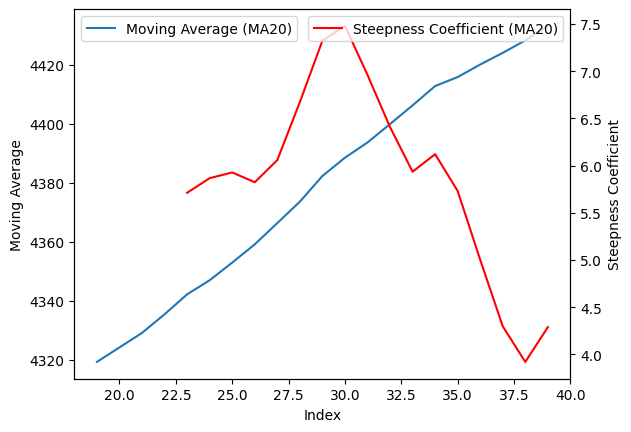

In [ ]:
# Plotting the moving average
plt.plot(data.iloc[0:40]['MA20'], label='Moving Average (MA20)')
plt.xlabel('Index')
plt.ylabel('Moving Average')
plt.legend(loc='upper left')

# Creating a twin axes
ax2 = plt.twinx()

# Plotting the steepness coefficient
ax2.plot(data.iloc[0:40]['Steepness_MA20'], color='red', label='Steepness Coefficient (MA20)')
ax2.set_ylabel('Steepness Coefficient')
ax2.legend(loc='upper right')

# Display the plot
plt.show()

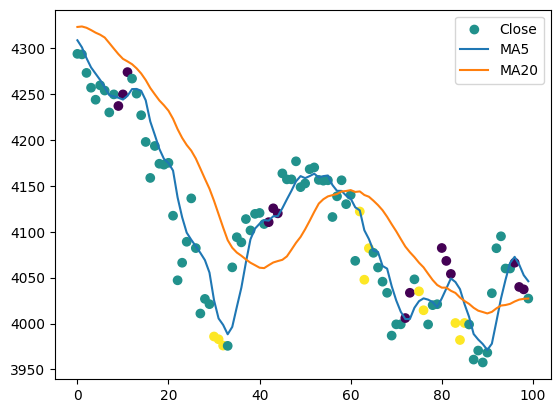

In [ ]:
plt.scatter(range(100), handler.data['Close'][100:200], c=handler.data['Label'][0:100], label="Close")
#plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][100:200], label=f"{ma_name}{ma1}")
#plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][100:200], label=f"{ma_name}{ma2}")
plt.plot(range(100), handler.data['MA5'][100:200], label='MA5')
plt.plot(range(100), handler.data['MA20'][100:200], label='MA20')
plt.legend()
plt.show()

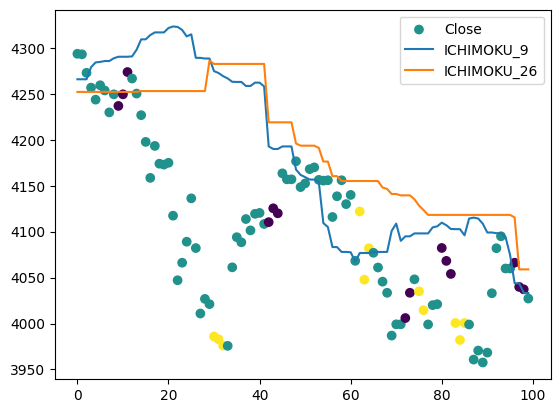

In [ ]:
plt.scatter(range(100), handler.data['Close'][100:200], c=handler.data['Label'][0:100], label="Close")
#plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][100:200], label=f"{ma_name}{ma1}")
#plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][100:200], label=f"{ma_name}{ma2}")
plt.plot(range(100), handler.data['ICHIMOKU_9'][100:200], label='ICHIMOKU_9')
plt.plot(range(100), handler.data['ICHIMOKU_26'][100:200], label='ICHIMOKU_26')
plt.legend()
plt.show()

[  9 198]
[ 77 297 480 717]
[403 507]
[480 717 909 981]
[578 665]
[ 909  981 1057 1191]
[749 952]
[1057 1191 1358 1442]
[1084 1530]
[1358 1442 1630 1713]
[1716 1849]
[1630 1713 1943]
[1911 1994]
[1943]


C:\Users\Alexis\AppData\Local\Temp\ipykernel_17880\650733363.py:69: RankWarning: Polyfit may be poorly conditioned
  trend_line_y = fit_trend_line(trend_line_x, price[valleys])


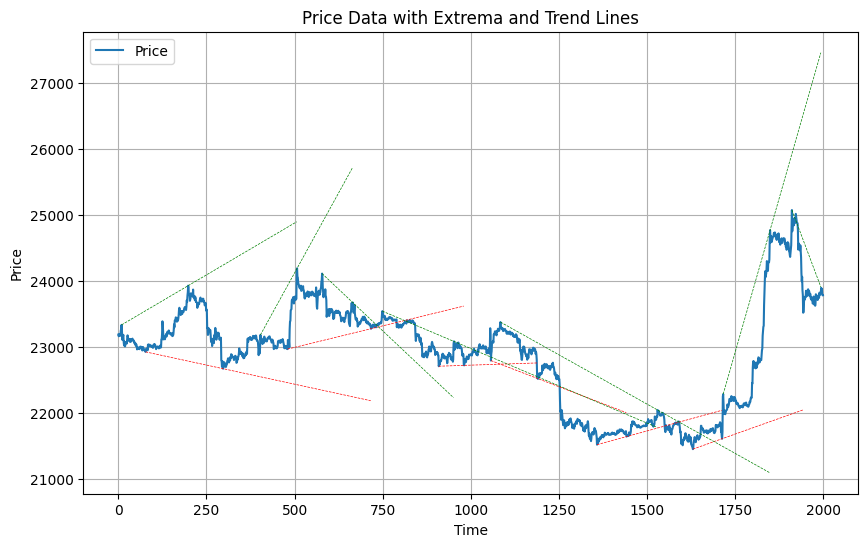

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.optimize import least_squares

def generate_price_data(n_points):
    x = np.linspace(0, 10, n_points)
    noise = np.random.normal(0, 0.1, n_points)
    price = np.sin(x) + noise
    return x, price

def find_extrema(price, order):
    peaks_idx = argrelextrema(price, np.greater, order=order)[0]
    valleys_idx = argrelextrema(price, np.less, order=order)[0]
    return peaks_idx, valleys_idx

def fit_trend_line(x, y):
    def objective_func(params, x, y):
        return params[0] * x + params[1] - y

    params_init = np.polyfit(x, y, 1)
    result = least_squares(objective_func, params_init, args=(x, y))
    return result.x

def plot_price_with_extrema_trend(x, price, peaks_idx, valleys_idx, support_lines, resistance_lines):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, price, label='Price')
    # plt.plot(x[peaks_idx], price[peaks_idx], 'ro', label='Peaks')
    # plt.plot(x[valleys_idx], price[valleys_idx], 'go', label='Valleys')

    # Plot trend lines
    for idx in support_lines:
        trend_line = support_lines[idx]
        plt.plot(trend_line[0], trend_line[1], 'r--', linewidth=0.5)

    for idx in support_lines:
        trend_line = resistance_lines[idx]
        plt.plot(trend_line[0], trend_line[1], 'g--', linewidth=0.5)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Price Data with Extrema and Trend Lines')
    plt.legend()
    plt.grid(True)
    plt.show()

window = 1000

# Generate price data
x, price = generate_price_data(100)
x, price = np.arange(window*2), np.array(handler.data['Close'])[-window*3:-window]

# Find extrema (peaks and valleys)
_, valleys_idx = find_extrema(price, 50)
peaks_idx, _ = find_extrema(price, 50)

# Define lookback thresholds
threshold = 2

# Fit trend lines based on lookback thresholds
support_lines = {}
resistance_lines = {}

i = 0
while i < valleys_idx.size:
    valleys = valleys_idx[i:i+threshold]
    trend_line_x = x[valleys]
    trend_line_y = fit_trend_line(trend_line_x, price[valleys])
    # print(trend_line_x, trend_line_y)

    valleys = valleys_idx[i:i+2*threshold]
    trend_line_x = x[valleys[0]:valleys[-1]]
    support_lines[i] = (trend_line_x, trend_line_y[0] * trend_line_x + trend_line_y[1])
    
    peaks = peaks_idx[i:i+threshold]
    print(peaks)
    print(valleys)
    trend_line_x = x[peaks]
    trend_line_y = fit_trend_line(trend_line_x, price[peaks])
    # print(trend_line_x, trend_line_y)

    peaks = peaks_idx[i:i+2*threshold]
    trend_line_x = x[peaks[0]:peaks[-1]]
    resistance_lines[i] = (trend_line_x, trend_line_y[0] * trend_line_x + trend_line_y[1])
    
    i += threshold

# Plot price data with extrema and trend lines
plot_price_with_extrema_trend(np.array(range(price.shape[0])), price, peaks_idx, valleys_idx, support_lines, resistance_lines)


In [ ]:
valleys_idx

array([  77,  297,  480,  717,  909,  981, 1057, 1191, 1358, 1442, 1630,
       1713, 1943], dtype=int64)